In [10]:
import pyterrier as pt
from sklearn.model_selection import train_test_split

In [2]:
if not pt.started():
  pt.init()

PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [3]:
import os

cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = './terrier_cord19_blocks'

if not os.path.exists(pt_index_path + "/data.properties"):
    # create the index, using the IterDictIndexer indexer 
    indexer = pt.index.IterDictIndexer(pt_index_path, blocks=True)

    # we give the dataset get_corpus_iter() directly to the indexer
    # while specifying the fields to index and the metadata to record
    index_ref = indexer.index(cord19.get_corpus_iter(), 
                              fields=('abstract',), 
                              meta=('docno',))

else:
    # if you already have the index, use it.
    index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")

index = pt.IndexFactory.of(index_ref)

cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]/var/folders/7q/cp_009r16hq1grqzhmglc5fc0000gp/T/ipykernel_36313/1563459286.py:12: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use constructor instead
  index_ref = indexer.index(cord19.get_corpus_iter(),
cord19/trec-covid documents:   0%|          | 16/192509 [00:01<5:56:55,  8.99it/s]

20:19:40.668 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (6iu1dtyl) - further warnings are suppressed


cord19/trec-covid documents: 100%|██████████| 192509/192509 [01:20<00:00, 2386.94it/s]

20:20:59.343 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Indexed 54937 empty documents


20:21:00.455 [ForkJoinPool-1-worker-3] ERROR org.terrier.structures.indexing.Indexer - Could not finish MetaIndexBuilder: 
java.io.IOException: Key 8lqzfj2e is not unique: 37597,11755
For MetaIndex, to suppress, set metaindex.compressed.reverse.allow.duplicates=true
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.mergeTwo(FSOrderedMapFile.java:1374)
	at org.terrier.structures.collections.FSOrderedMapFile$MultiFSOMapWriter.close(FSOrderedMapFile.java:1308)
	at org.terrier.structures.indexing.BaseMetaIndexBuilder.close(BaseMetaIndexBuilder.java:321)
	at org.terrier.structures.indexing.classical.BlockIndexer.createDirectIndex(BlockIndexer.java:472)
	at org.terrier.structures.indexing.Indexer.index(Indexer.java:369)
	at org.terrier.python.ParallelIndexer$1.apply(ParallelIndexer.java:63)
	at org.terrier.python.ParallelIndexer$1.apply(ParallelIndexer.java:52)
	at java.base/java.util.stream.ReferencePipeline$3$1.accept(ReferencePipeline.java:195)
	at java.base/java.u

In [4]:
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")

# check tfidf is a transformer...
print(isinstance(tfidf, pt.transformer.TransformerBase))
# this prints the type hierarchy of the TF_IDF class


True


In [5]:
tfidf.__class__.__mro__

(pyterrier.batchretrieve.BatchRetrieve,
 pyterrier.batchretrieve.BatchRetrieveBase,
 pyterrier.transformer.TransformerBase,
 pyterrier.transformer.Transformer,
 matchpy.expressions.expressions.Symbol,
 matchpy.expressions.expressions.Atom,
 matchpy.expressions.expressions.Expression,
 object)

In [6]:
# this is our first retrieval transformer
# it transform a queries dataframe to a results dataframe
tf = pt.BatchRetrieve(index, wmodel="Tf")

tf( cord19.get_topics(variant='title').head(1) )

/Users/hiromu.nakamura/ghq/github.com/po3rin/python_playground/.venv/lib/python3.9/site-packages/pyterrier/datasets.py:433: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


,qid,docid,docno,rank,score,query
0,1,146967,jkrj0lbm,0,25.0,coronavirus origin
1,1,25564,jlzncyax,1,18.0,coronavirus origin
2,1,45549,8l411r1w,2,15.0,coronavirus origin
3,1,29359,gnxbfcod,3,14.0,coronavirus origin
4,1,63537,cpc6v40g,4,14.0,coronavirus origin
...,...,...,...,...,...,...
995,1,58583,wfcyaumm,995,4.0,coronavirus origin
996,1,59153,86vu0kjm,996,4.0,coronavirus origin
997,1,59343,9n733bet,997,4.0,coronavirus origin
998,1,59478,mx58ai55,998,4.0,coronavirus origin


In [7]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
sdm = pt.rewrite.SDM()
qe = pt.rewrite.Bo1QueryExpansion(index)

In [8]:
sdm.search("chemical reactions").iloc[0]["query"]

'chemical reactions #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#1(chemical reactions)) #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#uw8(chemical reactions)) #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#uw12(chemical reactions))'

In [11]:
topics = cord19.get_topics(variant='title')
qrels = cord19.get_qrels()

/Users/hiromu.nakamura/ghq/github.com/po3rin/python_playground/.venv/lib/python3.9/site-packages/pyterrier/datasets.py:433: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


In [12]:
RANK_CUTOFF = 10
SEED=42

tr_va_topics, test_topics = train_test_split(topics, test_size=15, random_state=SEED)
train_topics, valid_topics =  train_test_split(tr_va_topics, test_size=5, random_state=SEED)


In [14]:
ltr_feats1 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(cord19, ["title", "date", "doi"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of text for query 'coronavirus covid'
    (pt.apply.query(lambda row: 'coronavirus covid') >> bm25)
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="title", takes='docs', wmodel='BM25') ) 
    ** # date 2020
    (pt.apply.doc_score(lambda row: int("2020" in row["date"])))
    ** # has doi
    (pt.apply.doc_score(lambda row: int( row["doi"] is not None and len(row["doi"]) > 0) ))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

# for reference, lets record the feature names here too
fnames=["BM25", "SDM", 'coronavirus covid', 'title', "2020", "hasDoi", "CoordinateMatch"]

In [15]:
ltr_feats1.search("coronovirus origin")

20:22:48.817 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,qid,docid,docno,rank,score,query,title,date,doi,features
0,1,188321,8bn74f2z,0,20.541477,coronovirus origin,Reply to Comments on 'Co‐infection of SARS‐CoV...,2020-04-08,10.1002/jmv.25838,"[20.541476673741375, 20.541476673741375, 2.899..."
1,1,93090,ciqs6l7e,1,19.859401,coronovirus origin,The spread of the COVID-19 coronavirus: Health...,2020,,"[19.859401180444888, 19.859401180444888, 2.803..."
2,1,93091,qe9w4qbu,2,19.859401,coronovirus origin,The spread of the COVID-19 coronavirus: Health...,2020,,"[19.859401180444888, 19.859401180444888, 2.803..."
3,1,152453,egzztatj,3,19.459604,coronovirus origin,The spread of the COVID‐19 coronavirus: Health...,2020-03-17,10.15252/embr.202050334,"[19.459604473560834, 19.459604473560834, 2.747..."
4,1,105298,9ci1u50r,4,18.009391,coronovirus origin,Placental Pathology in Covid-19 Positive Mothe...,2020,,"[18.009390548413062, 18.009390548413062, 0.0, ..."
5,1,175511,kdo2hir8,5,18.009391,coronovirus origin,Placental Pathology in Covid-19 Positive Mothe...,2020-05-12,10.1177/1093526620925569,"[18.009390548413062, 18.009390548413062, 0.0, ..."
6,1,97984,76laky91,6,16.673852,coronovirus origin,Cross-species transmission of the newly identi...,2020,,"[16.67385232414447, 16.67385232414447, 3.37300..."
7,1,97985,niytf3wo,7,16.673852,coronovirus origin,Cross-species transmission of the newly identi...,2020,,"[16.67385232414447, 16.67385232414447, 3.37300..."
8,1,97986,262bcl7h,8,16.673852,coronovirus origin,Cross-species transmission of the newly identi...,2020,,"[16.67385232414447, 16.67385232414447, 3.37300..."
9,1,97987,nip1ax1x,9,16.673852,coronovirus origin,Cross-species transmission of the newly identi...,2020,,"[16.67385232414447, 16.67385232414447, 3.37300..."


In [16]:
ltr_feats1.search("coronovirus origin").iloc[0]["features"]

20:23:46.940 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


array([20.54147667, 20.54147667,  2.89976767,  0.        ,  1.        ,
        1.        ,  1.        ])

In [17]:
import fastrank

train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe.fit(train_topics, cord19.get_qrels())

20:25:43.330 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/hiromu.nakamura/ghq/github.com/po3rin/python_playground/.venv/lib/python3.9/site-packages/pyterrier/transformer.py:789: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x147ed5f10>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any "


---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
   3|6               |    0.065|    0.769
   1|6               |   -0.318|    0.778
   2|6               |    0.046|    0.817
   1|6               |   -0.618|    0.778
   2|6               |    0.0

In [18]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(rf)

%time rf_pipe.fit(train_topics, cord19.get_qrels())

20:26:21.496 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/Users/hiromu.nakamura/ghq/github.com/po3rin/python_playground/.venv/lib/python3.9/site-packages/pyterrier/transformer.py:789: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x147ed5f10>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any "
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.9s


CPU times: user 13.1 s, sys: 335 ms, total: 13.5 s
Wall time: 9.45 s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    4.1s finished


In [21]:
# import lightgbm as lgb

# # this configures LightGBM as LambdaMART
# lmart_l = lgb.LGBMRanker(
#     task="train",
#     silent=False,
#     min_data_in_leaf=1,
#     min_sum_hessian_in_leaf=1,
#     max_bin=255,
#     num_leaves=31,
#     objective="lambdarank",
#     metric="ndcg",
#     ndcg_eval_at=[10],
#     ndcg_at=[10],
#     eval_at=[10],
#     learning_rate= .1,
#     importance_type="gain",
#     num_iterations=100,
#     early_stopping_rounds=5
# )

# lmart_x_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

# %time lmart_x_pipe.fit(train_topics, cord19.get_qrels(), valid_topics, cord19.get_qrels())

In [23]:
pt.Experiment(
    [bm25 % RANK_CUTOFF, ca_pipe, rf_pipe],
    test_topics,
    qrels, 
    names=["BM25",  "BM25 + CA(7f)", "BM25 + RF(7f)"],
    baseline=0,
    eval_metrics=["map", "ndcg", "ndcg_cut_10"])

20:31:09.366 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:31:11.198 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


,name,map,ndcg,ndcg_cut_10,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,BM25,0.010480,0.043844,0.537236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 + CA(7f),0.011797,0.048222,0.575253,10.0,2.0,0.031991,9.0,5.0,0.066382,9.0,5.0,0.079595
2,BM25 + RF(7f),0.011271,0.045830,0.551404,8.0,3.0,0.216817,9.0,4.0,0.233364,9.0,4.0,0.420787


In [24]:
pt.Experiment(
    [ltr_feats1 >> pt.ltr.feature_to_score(i) for i in range(len(fnames))],
    test_topics,
    qrels, 
    names=fnames,
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "num_rel_ret"])

20:32:04.951 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:32:07.105 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:32:08.813 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
20:32:10.488 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

,name,map,ndcg,ndcg_cut_10,num_rel_ret
0,BM25,0.010480,0.043844,0.537236,95.0
1,SDM,0.010429,0.043568,0.535770,95.0
2,coronavirus covid,0.011637,0.046777,0.562223,95.0
3,title,0.011799,0.047354,0.567363,95.0
4,2020,0.011064,0.045604,0.555846,95.0
5,hasDoi,0.009928,0.042970,0.531974,95.0
6,CoordinateMatch,0.010742,0.044333,0.540893,95.0


/var/folders/7q/cp_009r16hq1grqzhmglc5fc0000gp/T/ipykernel_36313/1053339105.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


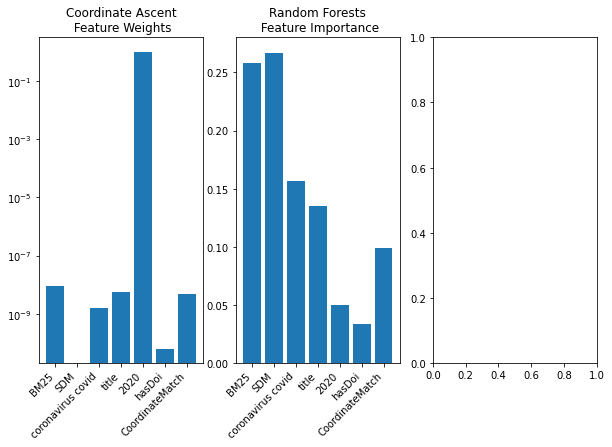

In [26]:
import matplotlib.pyplot as plt, numpy as np

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 6))

ax0.bar(np.arange(len(fnames)), ca_pipe[1].model.to_dict()['Linear']['weights'])
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("Coordinate Ascent\n Feature Weights")
ax0.set_yscale('log')

ax1.bar(np.arange(len(fnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance")

# ax2.bar(np.arange(len(fnames)), lmart_l.feature_importances_)
# ax2.set_xticks(np.arange(len(fnames)))
# ax2.set_xticklabels(fnames, rotation=45, ha='right')
# ax2.set_title("$\lambda$MART\n Feature Importance")

fig.show()